### Analysis on qw16 unit OPER data

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import pymongo
import joblib
import os
import shap
from dotenv import load_dotenv
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split


c:\Users\TSiHao\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Reading pickle files from NLA_Analysis

In [2]:
NLA_merged_df = pd.read_pickle('Created_files/NLA_merged_df.pkl')
NLA_merged_df

,YDF ROC,Vendor,prod_id,I /A,TFB,LD9 base/oC,CPS Top (mon card),PD1/V,PD2/V
0,4.8cm,NL,NL1,seed on,25.50,25.75,20.24,0.02,0.00
1,4.8cm,NL,NL1,Pramp1 On,25.00,25.50,20.71,5.02,0.00
2,4.8cm,NL,NL1,PreAMP2 on,25.00,25.50,21.65,9.99,0.00
3,4.8cm,NL,NL1,1,25.75,25.75,22.12,9.99,0.01
4,4.8cm,NL,NL1,2,26.25,25.75,24.00,9.99,0.09
...,...,...,...,...,...,...,...,...,...
188,4cm,NF,NL16,6,28.50,26.25,26.35,9.99,1.22
189,4cm,NF,NL16,8,29.75,26.50,28.24,9.99,2.31
190,4cm,NF,NL16,10,31.00,26.75,29.65,9.99,3.81
191,4cm,NF,NL16,11,31.50,27.00,31.06,9.99,4.19


In [3]:
#Standadising unit names
unit_info_df = pd.read_pickle('Created_files/unit_info_df.pkl')
unit_info_df['unit_names'] = unit_info_df['Unit'].str.replace(r'^N?L(\d+)$', lambda x: 'L{:02d}'.format(int(x.group(1))), regex=True)
unit_info_df = unit_info_df.drop(0)
unit_info_df

,Unit,YDF ROC,Vendor,unit_names
1,NL1,4.8cm,NL,L01
2,NL2,4.9cm,NL,L02
3,NL3,4cm,NF,L03
4,NL4,4.9cm,NL,L04
5,NL5,4.8cm,NL,L05
6,NL6,4.7cm,NL,L06
7,NL7,4.7cm,NL,L07
8,NL8,4cm,NF,L08
9,NL9,4.8cm,NL,L09
10,NL10,4.8cm,NL,L10


### Information about the Channels

In [4]:
channel_file_path = 'Data/qw 16 ch placement.xlsx'
channel_df = pd.read_excel(channel_file_path)
channel_df

,ch (oper log id),PREV PROD ID,prod id,Wavelength (nm),Remarks,Further Remarks
0,1,NaN,NL16V2,1045.6,checked on rack,v2 means nufern v2
1,2,NaN,NL11,1053.3,checked on rack,NaN
2,3,NaN,NL8V2,1062.1,checked on rack,NaN
3,4,NLA1,NLA201,1043.4,checked on rack,NaN
4,5,NaN,NLA3V2,1065.4,checked on rack,ST
5,6,NaN,NL12,1047.8,missing,NaN
6,7,NaN,NL15,1050.0,checked on rack,NaN
7,8,NaN,NL7V2,1055.5,checked on rack,NaN
8,9,NaN,NL4,1057.7,checked on rack,First original 16
9,10,NaN,NLA102,1059.9,checked on rack,10x is built by ST for CASA


### Pulling and creating `lxx_data.csv` from MongoDB Local
*Take note: Input username and password in a `secrets.env` file in the format of LOCAL_MONGO_URI=mongodb://localhost:27017*

In [63]:
# MongoDB connection details
load_dotenv("secrets.env")
mongo_uri = os.environ.get("LOCAL_MONGO_URI")
database_name = "qw_16_unit_oper_data"
collection_name = "final_lxx_data"

# Connect to MongoDB Atlas
client = pymongo.MongoClient(mongo_uri)
db = client[database_name]
collection = db[collection_name]

# Define batch size
batch_size = 1000

# Fetch data from MongoDB using cursor with batch size
cursor = collection.find().batch_size(batch_size)

# Iterate over the cursor and append documents to data_list
data_list = []
for document in cursor:
    data_list.append(document)

# Convert list of dictionaries to DataFrame
df = pd.DataFrame(data_list)

# Drop the '_id' column
df = df.drop(columns=['_id'])

# Save DataFrame to CSV
csv_path = 'Created_files/lxx_data.csv'
df.to_csv(csv_path, index=False)

print(f"Data exported successfully to {csv_path}.")


Data exported successfully to Created_files/lxx_data.csv.


### Pulling and creating `psu_data.csv` from MongoDB Local

In [4]:
collection_name = "final_psu_data"

# Connect to MongoDB
client = pymongo.MongoClient(mongo_uri)
db = client[database_name]
collection = db[collection_name]

# Define batch size
batch_size = 1000

# Fetch data from MongoDB using cursor with batch size
cursor = collection.find().batch_size(batch_size)

# Iterate over the cursor and append documents to data_list
data_list = []
for document in cursor:
    data_list.append(document)

# Convert list of dictionaries to DataFrame
df = pd.DataFrame(data_list)

# Drop the '_id' column
df = df.drop(columns=['_id'])

# Save DataFrame to CSV
csv_path = 'Created_files/psu_data.csv'
df.to_csv(csv_path, index=False)

print(f"Data exported successfully to {csv_path}.")


Data exported successfully to Created_files/psu_data.csv.


### Cached psu data stored as `lxx_df`

In [5]:
lxx_file_path = 'Created_files/lxx_data.csv'
final_lxx_df = pd.read_csv(lxx_file_path)
final_lxx_df['Date_Time'] = final_lxx_df['Date_Time'].str.replace('.', ':')
final_lxx_df

,Date_Time,Lxx,TC_LD,TC_CMB,TC_CPS,PD1,PD2
0,2024-03-26 11:15:16:495,L16,24.75,24.25,21.29,9.99,0.03
1,2024-03-26 11:15:16:416,L16,24.75,24.25,21.29,8.41,0.01
2,2024-03-26 11:15:16:534,L16,24.75,24.25,21.29,9.99,0.03
3,2024-03-26 11:15:16:572,L16,25.00,24.25,21.29,9.99,0.02
4,2024-03-26 11:15:16:652,L16,24.75,24.25,21.29,9.99,0.03
...,...,...,...,...,...,...,...
490931,2024-04-16 14:06:05:517,L16,32.25,27.25,29.76,9.99,0.03
490932,2024-04-16 14:06:05:556,L16,32.25,27.25,29.76,9.99,0.03
490933,2024-04-16 14:06:05:287,L16,32.50,27.25,29.76,9.99,0.03
490934,2024-04-16 14:06:05:671,L16,32.25,27.25,29.29,6.97,0.02


### Cached psu data stored as `psu_df`

In [6]:
psu_file_path = 'Created_files/psu_data.csv'
final_psu_df = pd.read_csv(psu_file_path)
final_psu_df['Date_Time'] = final_psu_df['Date_Time'].str.replace('.', ':')
final_psu_df

,Date_Time,PSUx,I_MEAS
0,2024-03-26 10:47:05:966,PSU10,0.01
1,2024-03-26 10:47:06:466,PSU10,0.01
2,2024-03-26 10:47:06:949,PSU10,0.01
3,2024-03-26 10:47:07:358,PSU10,0.01
4,2024-03-26 10:47:07:933,PSU10,0.01
...,...,...,...
173914,2024-04-16 14:06:41:693,PSU16,0.01
173915,2024-04-16 14:06:41:776,PSU07,0.01
173916,2024-04-16 14:06:41:940,PSU02,0.01
173917,2024-04-16 14:06:42:017,PSU04,0.03


### Displaying distribution of columns in `final_lxx_df` (ALL UNITS)

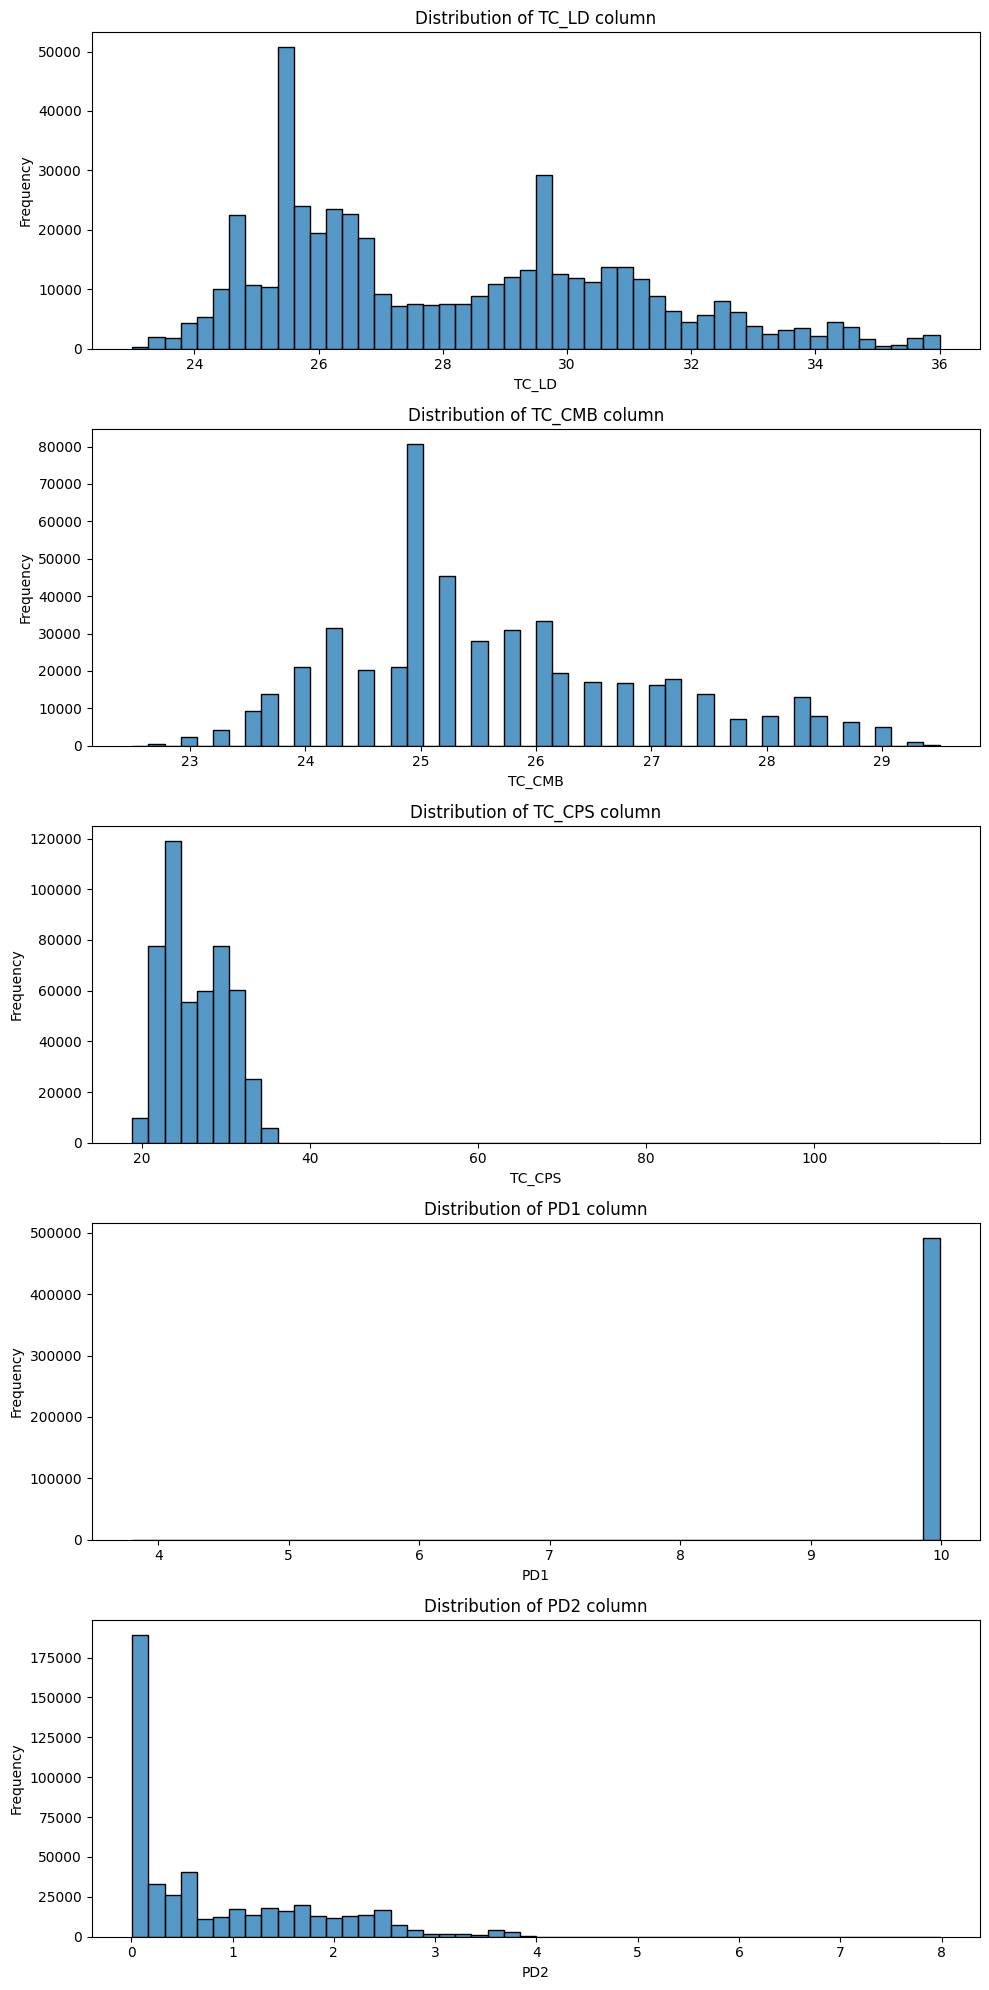

In [7]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
columns = ['TC_LD', 'TC_CMB', 'TC_CPS', 'PD1', 'PD2']
for i, col in enumerate(columns):
    sns.histplot(data=final_lxx_df, x=col, bins=50, ax=axes[i])  
    axes[i].set_title(f'Distribution of {col} column')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


### Linking PSUx with its respective Lxx (Eg. L01 with PSU01)

In [8]:
final_psu_df.loc[:, 'Lxx'] = 'L' + final_psu_df['PSUx'].str.extract(r'(\d+)', expand=False)
final_psu_df

,Date_Time,PSUx,I_MEAS,Lxx
0,2024-03-26 10:47:05:966,PSU10,0.01,L10
1,2024-03-26 10:47:06:466,PSU10,0.01,L10
2,2024-03-26 10:47:06:949,PSU10,0.01,L10
3,2024-03-26 10:47:07:358,PSU10,0.01,L10
4,2024-03-26 10:47:07:933,PSU10,0.01,L10
...,...,...,...,...
173914,2024-04-16 14:06:41:693,PSU16,0.01,L16
173915,2024-04-16 14:06:41:776,PSU07,0.01,L07
173916,2024-04-16 14:06:41:940,PSU02,0.01,L02
173917,2024-04-16 14:06:42:017,PSU04,0.03,L04


### Grouping Lxx and PSUx of the same number togther, sorted by `date_time`

In [9]:
merged_df = pd.merge(final_psu_df, final_lxx_df, on=['Date_Time', 'Lxx'], how='outer')
unique_lxx_values = merged_df['Lxx'].unique()
lxx_dfs = {}

# Creating dataframes based on all unit_names detected
for lxx in unique_lxx_values:
    lxx_df = merged_df[merged_df['Lxx'] == lxx].copy()

    lxx_df.loc[lxx_df['PSUx'].isna(), 'PSUx'] = lxx_df.loc[lxx_df['PSUx'].isna(), 'Lxx']
    
    lxx_df.drop(columns=['Lxx'], inplace=True)

    lxx_df.rename(columns={'PSUx': 'unit_names'}, inplace=True)
    
    # Forward filling the most recently captured I_MEAS and tag
    lxx_df['I_MEAS'] = lxx_df['I_MEAS'].ffill()
    
    # Add the completed dataframe into the full dictionary
    lxx_dfs[lxx] = lxx_df

datetime_format = "%Y-%m-%d %H:%M:%S:%f"
for lxx, df in lxx_dfs.items():
    df['Date_Time'] = pd.to_datetime(df['Date_Time'], format=datetime_format)
    df['I_MEAS'] = df['I_MEAS'].ffill()

lxx_dfs


{'L10':                      Date_Time unit_names  I_MEAS  TC_LD  TC_CMB  TC_CPS  PD1  \
 0      2024-03-26 10:47:05.966      PSU10    0.01    NaN     NaN     NaN  NaN   
 1      2024-03-26 10:47:06.466      PSU10    0.01    NaN     NaN     NaN  NaN   
 2      2024-03-26 10:47:06.949      PSU10    0.01    NaN     NaN     NaN  NaN   
 3      2024-03-26 10:47:07.358      PSU10    0.01    NaN     NaN     NaN  NaN   
 4      2024-03-26 10:47:07.933      PSU10    0.01    NaN     NaN     NaN  NaN   
 ...                        ...        ...     ...    ...     ...     ...  ...   
 663778 2024-04-16 14:06:30.021      PSU10    0.01    NaN     NaN     NaN  NaN   
 663783 2024-04-16 14:06:30.432      PSU10    0.01    NaN     NaN     NaN  NaN   
 663788 2024-04-16 14:06:30.821      PSU10    0.01    NaN     NaN     NaN  NaN   
 663793 2024-04-16 14:06:31.223      PSU10    0.01    NaN     NaN     NaN  NaN   
 663798 2024-04-16 14:06:31.590      PSU10    0.01    NaN     NaN     NaN  NaN   
 
       

### Dropping all rows for which belongs to a laser unit but has no current readings tagged

In [10]:
# Dropping instances of PSU rows with no I_MEAS reading
for key, df in lxx_dfs.items():
    df.drop(df[(df['unit_names'] == key) & (df['I_MEAS'].isna())].index, inplace=True)
lxx_dfs

{'L10':                      Date_Time unit_names  I_MEAS  TC_LD  TC_CMB  TC_CPS  PD1  \
 0      2024-03-26 10:47:05.966      PSU10    0.01    NaN     NaN     NaN  NaN   
 1      2024-03-26 10:47:06.466      PSU10    0.01    NaN     NaN     NaN  NaN   
 2      2024-03-26 10:47:06.949      PSU10    0.01    NaN     NaN     NaN  NaN   
 3      2024-03-26 10:47:07.358      PSU10    0.01    NaN     NaN     NaN  NaN   
 4      2024-03-26 10:47:07.933      PSU10    0.01    NaN     NaN     NaN  NaN   
 ...                        ...        ...     ...    ...     ...     ...  ...   
 663778 2024-04-16 14:06:30.021      PSU10    0.01    NaN     NaN     NaN  NaN   
 663783 2024-04-16 14:06:30.432      PSU10    0.01    NaN     NaN     NaN  NaN   
 663788 2024-04-16 14:06:30.821      PSU10    0.01    NaN     NaN     NaN  NaN   
 663793 2024-04-16 14:06:31.223      PSU10    0.01    NaN     NaN     NaN  NaN   
 663798 2024-04-16 14:06:31.590      PSU10    0.01    NaN     NaN     NaN  NaN   
 
       

### Joblib save dictionary

In [18]:
joblib.dump(lxx_dfs, 'Created_files/lxx_dfs.pkl')

['Created_files/lxx_dfs.pkl']

### Creating individual merged dataframes

In [11]:
# Function created to query any specific dataframe within the dictionary
def extract_specific_lxx_table(key):
    return lxx_dfs.get(key)

dataframes = []
sorted_unit_names = sorted(final_lxx_df['Lxx'].unique())

# Creating actual individual dataframe and storing as global variable
for unit_name in sorted_unit_names:
    unit_df = extract_specific_lxx_table(unit_name)
    globals()[f"{unit_name}_df"] = unit_df
    dataframes.append(f"{unit_name}_df")
    
print("Dataframes created: ", dataframes)


Dataframes created:  ['L02_df', 'L03_df', 'L04_df', 'L05_df', 'L06_df', 'L07_df', 'L08_df', 'L09_df', 'L10_df', 'L11_df', 'L12_df', 'L13_df', 'L14_df', 'L15_df', 'L16_df']


### A look into how component temperature (Eg. `TC_LD`) are affected by the current level (`I_MEAS`)

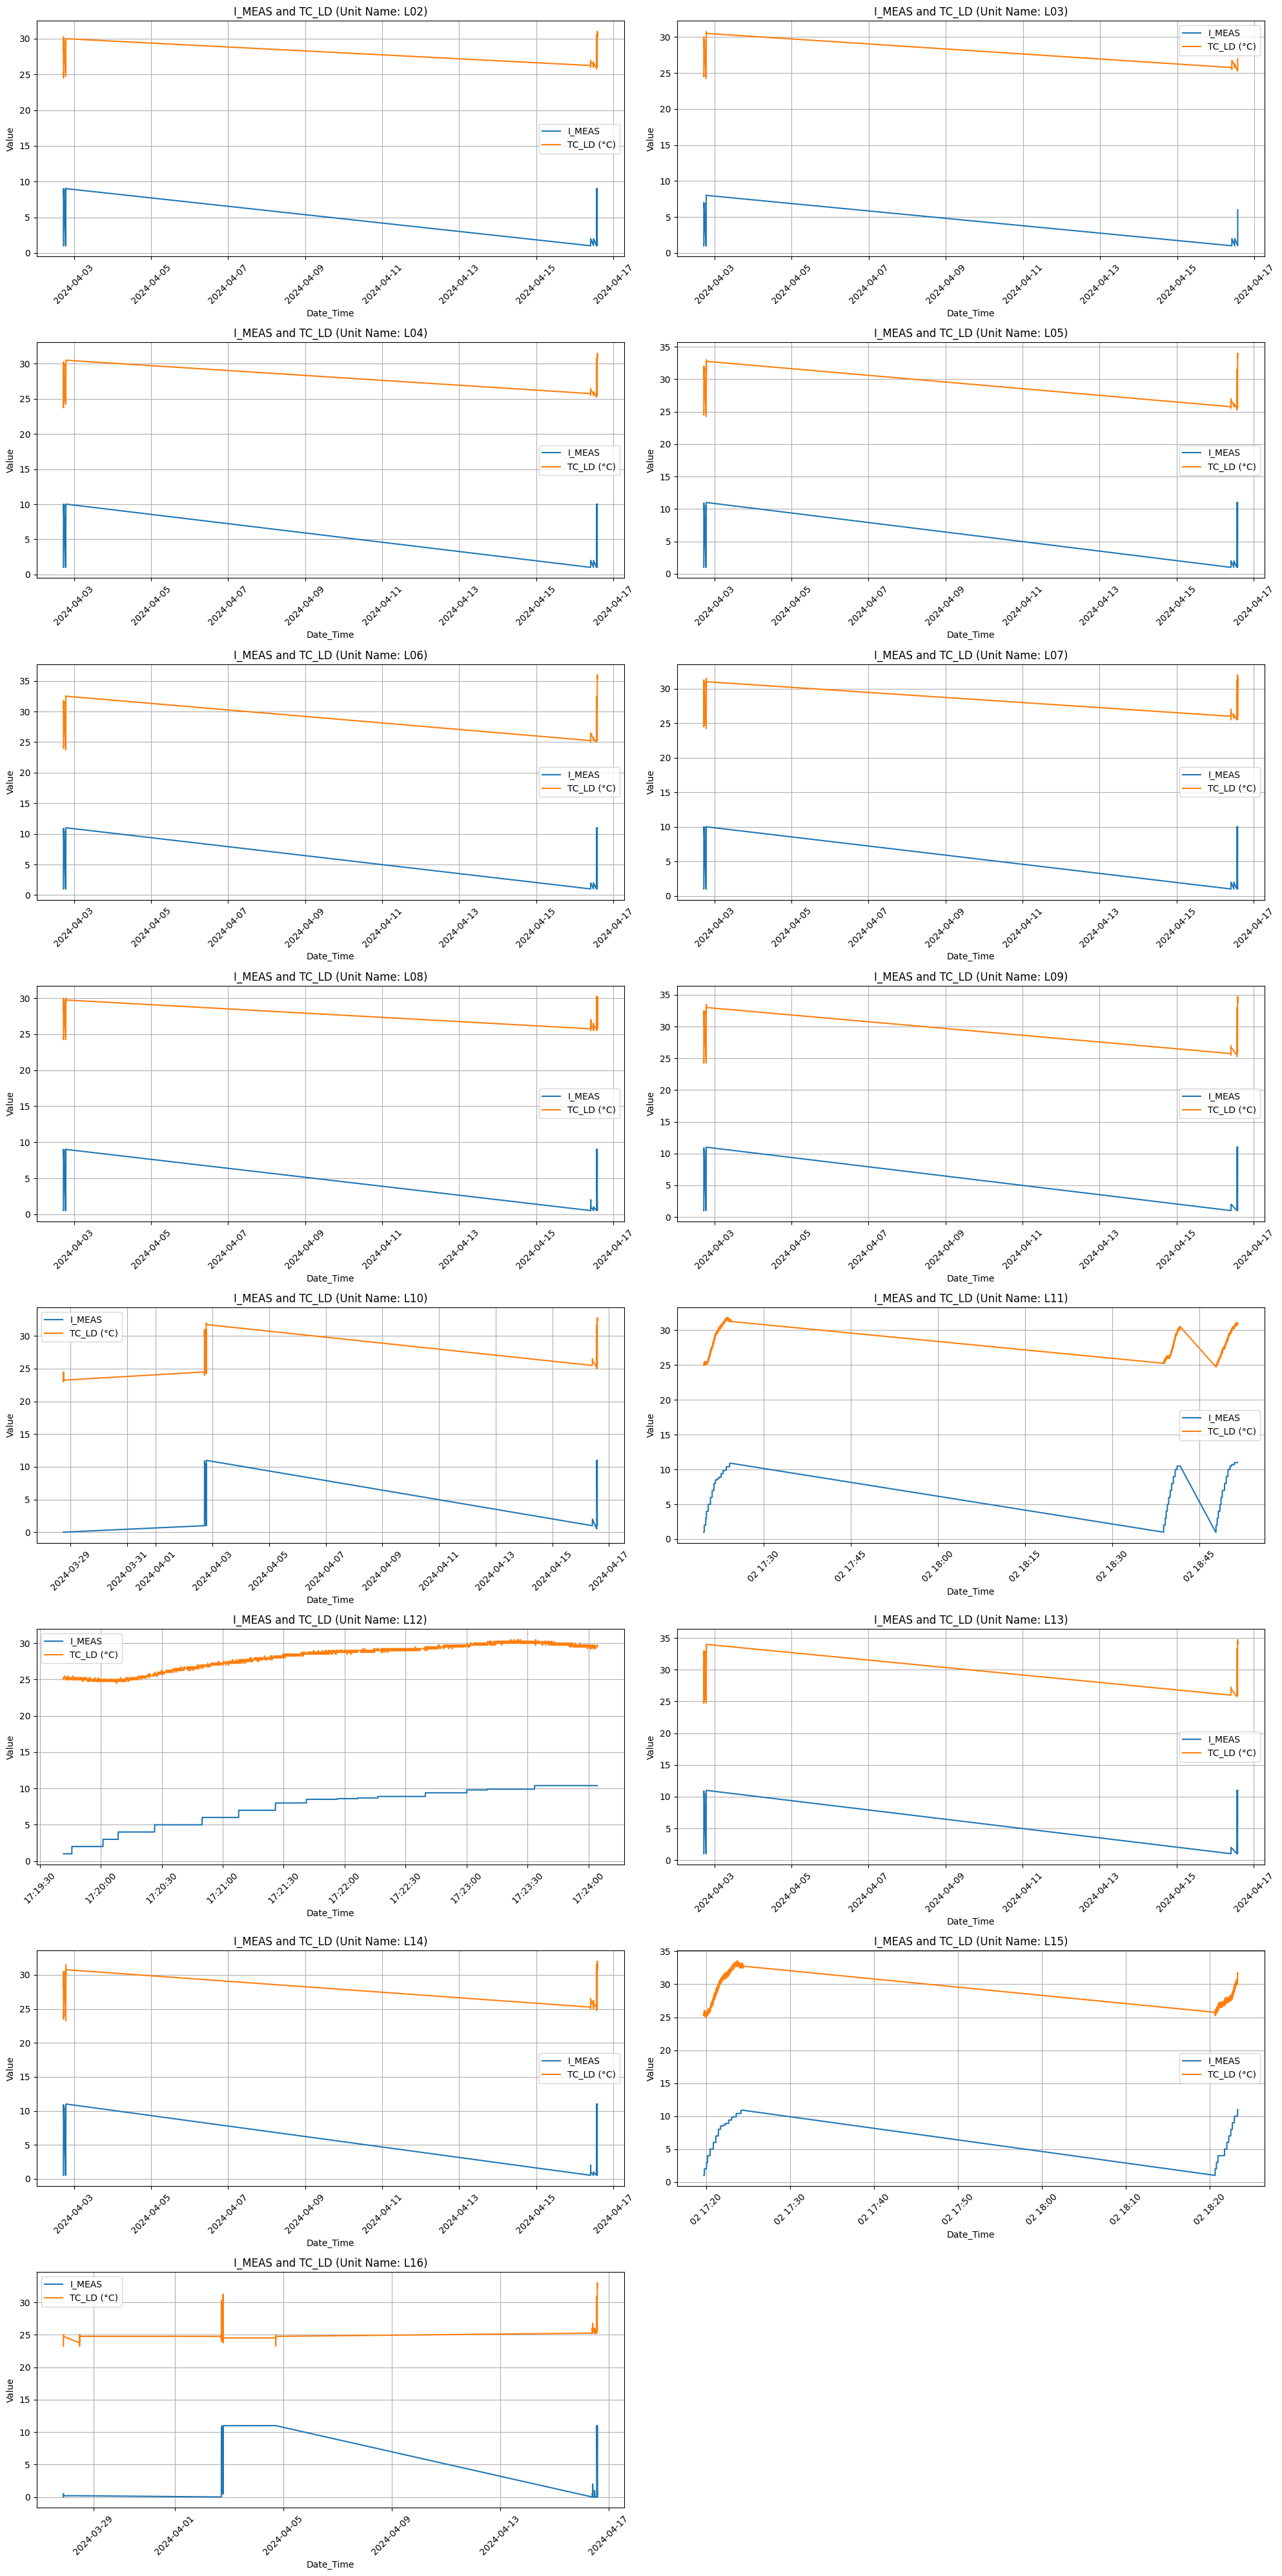

In [12]:
# Define the number of rows and columns for the subplot grid
nrows, ncols = 8, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 40))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop through each DataFrame and plot on the corresponding subplot
for i, df_name in enumerate(dataframes):
    # Get the DataFrame from the globals() dictionary
    df = globals()[df_name]
    
    # Filter the DataFrame for the specific unit name
    unit_name = df_name.split('_')[0]  # Extract unit name from the DataFrame name
    unit_df = df[df['unit_names'] == unit_name]
    
    # Plot both 'I_MEAS' and 'TC_LD' on the same graph
    axes[i].plot(unit_df['Date_Time'], unit_df['I_MEAS'], label='I_MEAS')
    axes[i].plot(unit_df['Date_Time'], unit_df['TC_LD'], label='TC_LD (°C)')
    axes[i].set_xlabel('Date_Time')
    axes[i].set_ylabel('Value')
    axes[i].set_title(f'I_MEAS and TC_LD (Unit Name: {unit_name})')
    axes[i].legend()
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True)
axes[15].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


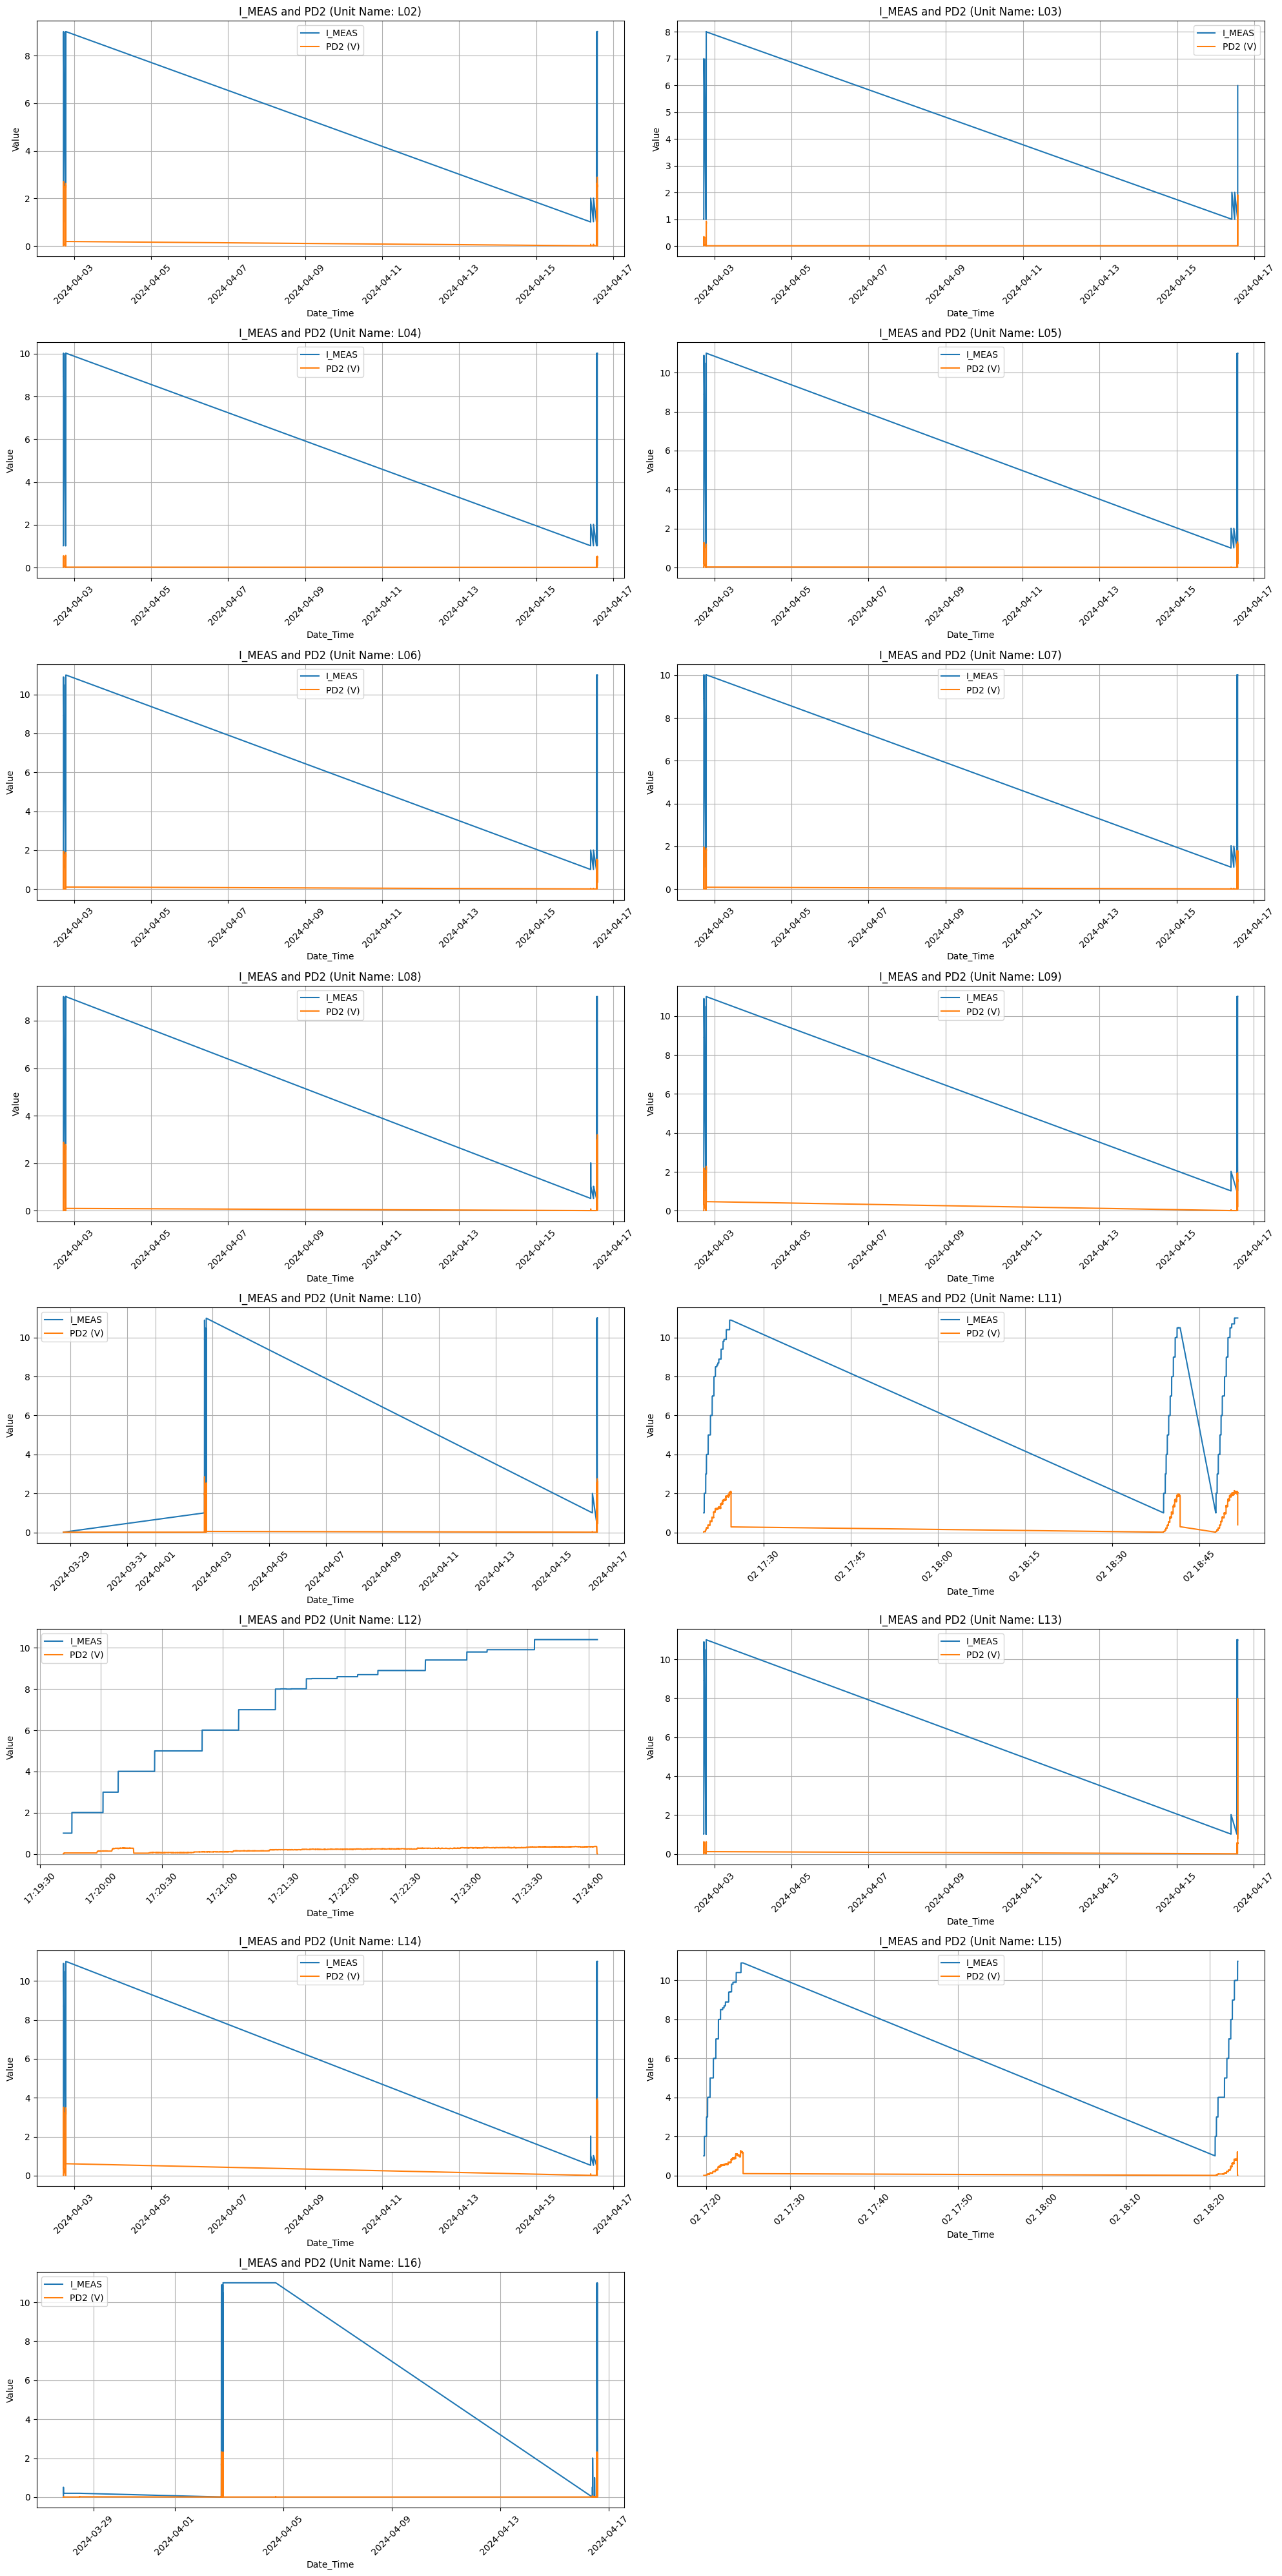

In [81]:
# Define the number of rows and columns for the subplot grid
nrows, ncols = 8, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 40))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop through each DataFrame and plot on the corresponding subplot
for i, df_name in enumerate(dataframes):
    # Get the DataFrame from the globals() dictionary
    df = globals()[df_name]
    
    # Filter the DataFrame for the specific unit name
    unit_name = df_name.split('_')[0]  # Extract unit name from the DataFrame name
    unit_df = df[df['unit_names'] == unit_name]
    
    # Plot both 'I_MEAS' and 'TC_LD' on the same graph
    axes[i].plot(unit_df['Date_Time'], unit_df['I_MEAS'], label='I_MEAS')
    axes[i].plot(unit_df['Date_Time'], unit_df['PD2'], label='PD2 (V)')
    axes[i].set_xlabel('Date_Time')
    axes[i].set_ylabel('Value')
    axes[i].set_title(f'I_MEAS and PD2 (Unit Name: {unit_name})')
    axes[i].legend()
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True)
axes[15].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


**General observations from lineplots examples using TC_LD & PD2**

From the above plots, we can see that there are a constant sign of drastic decrease in the temperature over a long period of time before rising back, signalling that the units are activated once, and then again some other time in the future. In other words, the readings need to be taken in batches.

### Inspecting the 3 obvious subparts in plot of `L11_df` as a zoom in on its `TC_LD` reading as an example

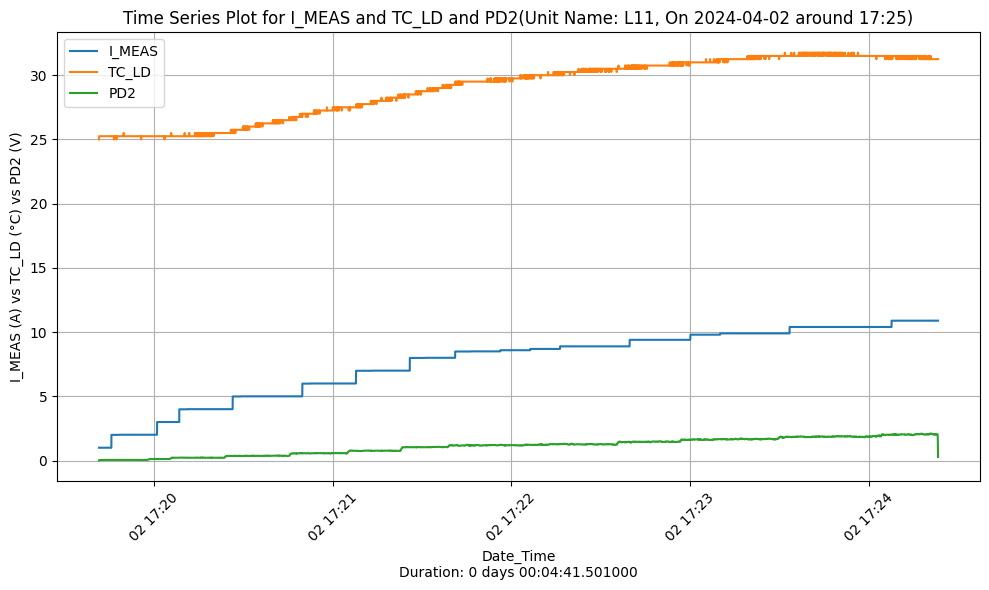

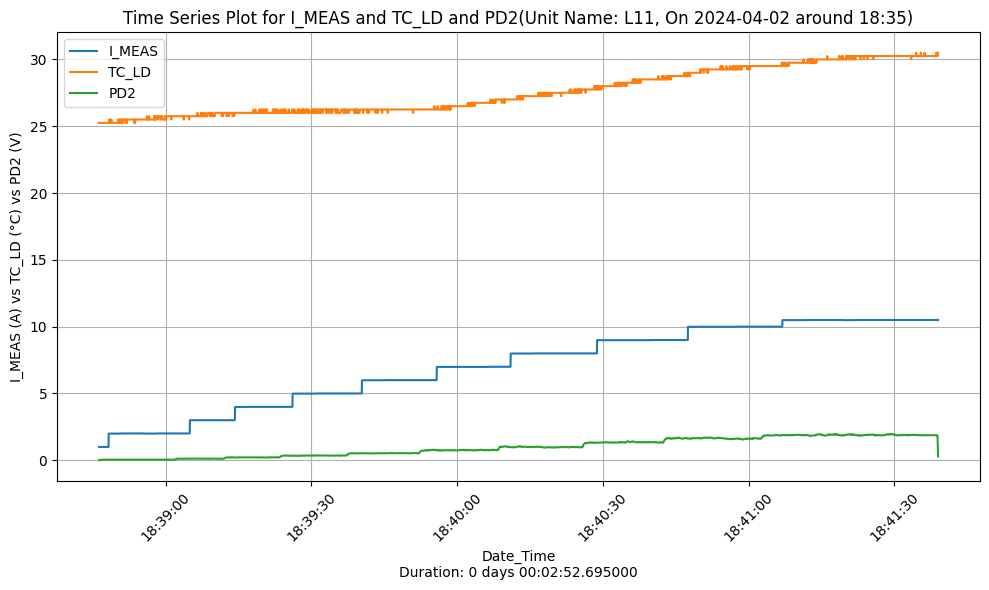

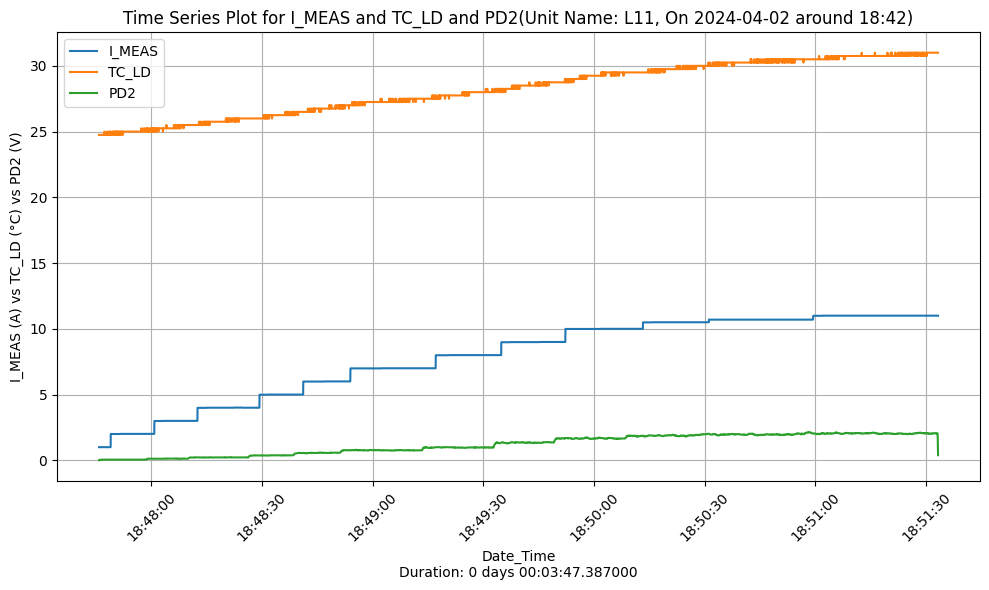

In [13]:
def plot_TCLD_subpart(df, duration, title):
    plt.figure(figsize=(10, 6))
    plt.plot(df['Date_Time'], df['I_MEAS'], label='I_MEAS')
    plt.plot(df['Date_Time'], df['TC_LD'], label='TC_LD')
    plt.plot(df['Date_Time'], df['PD2'], label='PD2')
    plt.xlabel(f'Date_Time\nDuration: {duration}')
    plt.ylabel('I_MEAS (A) vs TC_LD (°C) vs PD2 (V)')
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Filtering data
L11_unit_df = L11_df[L11_df['unit_names'] == 'L11']

L11_df_subpart1 = L11_unit_df[L11_unit_df['Date_Time'] < '2024-04-02 17:25']
L11_df_subpart2 = L11_unit_df[(L11_unit_df['Date_Time'] > '2024-04-02 18:35') & (L11_unit_df['Date_Time'] < '2024-04-02 18:42')]
L11_df_subpart3 = L11_unit_df[L11_unit_df['Date_Time'] > '2024-04-02 18:42']

# Calculating durations
duration_subpart1 = L11_df_subpart1['Date_Time'].max() - L11_df_subpart1['Date_Time'].min()
duration_subpart2 = L11_df_subpart2['Date_Time'].max() - L11_df_subpart2['Date_Time'].min()
duration_subpart3 = L11_df_subpart3['Date_Time'].max() - L11_df_subpart3['Date_Time'].min()

# Plotting subparts
plot_TCLD_subpart(L11_df_subpart1, duration_subpart1, 'Time Series Plot for I_MEAS and TC_LD and PD2(Unit Name: L11, On 2024-04-02 around 17:25)')
plot_TCLD_subpart(L11_df_subpart2, duration_subpart2, 'Time Series Plot for I_MEAS and TC_LD and PD2(Unit Name: L11, On 2024-04-02 around 18:35)')
plot_TCLD_subpart(L11_df_subpart3, duration_subpart3, 'Time Series Plot for I_MEAS and TC_LD and PD2(Unit Name: L11, On 2024-04-02 around 18:42)')

### Denoting the most commonly appeared temperature for any current setting 

In [14]:
def get_most_common_tc_ld(subpart_df):
    mode_TC_LD_per_I_MEAS = subpart_df.groupby('I_MEAS')['TC_LD'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).reset_index()
    mode_TC_LD_per_I_MEAS.columns = ['I_MEAS', 'Most_Common_TC_LD']
    return mode_TC_LD_per_I_MEAS

# Get the most common TC_LD for each subpart
subpart1_result = get_most_common_tc_ld(L11_df_subpart1)
subpart2_result = get_most_common_tc_ld(L11_df_subpart2)
subpart3_result = get_most_common_tc_ld(L11_df_subpart3)

# Rename columns to identify subparts
subpart1_result.columns = ['I_MEAS', 'Most_Common_TC_LD_Subpart1']
subpart2_result.columns = ['I_MEAS', 'Most_Common_TC_LD_Subpart2']
subpart3_result.columns = ['I_MEAS', 'Most_Common_TC_LD_Subpart3']

# Merge the results side by side on I_MEAS
combined_result = pd.merge(subpart1_result, subpart2_result, on='I_MEAS', how='outer')
final_combined_result = pd.merge(combined_result, subpart3_result, on='I_MEAS', how='outer')

final_combined_result

,I_MEAS,Most_Common_TC_LD_Subpart1,Most_Common_TC_LD_Subpart2,Most_Common_TC_LD_Subpart3
0,1.00,25.25,25.25,24.75
1,2.00,25.25,25.50,24.75
2,2.01,25.25,25.75,25.00
3,2.99,NaN,NaN,25.25
4,3.00,25.25,25.75,25.50
5,3.99,25.25,26.00,25.50
6,4.00,25.50,26.00,26.00
7,4.01,NaN,NaN,26.00
8,4.99,25.75,26.00,26.00
9,5.00,26.25,26.25,26.25


### Setting min-max temperature of what was captured during the runs for each of the units


In [15]:
all_results = []

agg_funcs = {
    'TC_LD': ['min', 'max'],
    'TC_CMB': ['min', 'max'],
    'TC_CPS': ['min', 'max'],
    'PD2': ['min', 'max']
}

# Tracking within each individual dataframe, the min and max of each of the features
for df_name in dataframes:
    df = globals()[df_name]

    filtered_df = df[df['I_MEAS'] >= 1]

    result = filtered_df.groupby('I_MEAS').agg(agg_funcs).reset_index()
 
    result.columns = ['_'.join(col).strip() if col[1] else col[0] for col in result.columns.values]

    result.rename(columns={
        'I_MEAS_': 'I_MEAS',
        'TC_LD_min': 'Min_TC_LD',
        'TC_LD_max': 'Max_TC_LD',
        'TC_CMB_min': 'Min_TC_CMB',
        'TC_CMB_max': 'Max_TC_CMB',
        'TC_CPS_min': 'Min_TC_CPS',
        'TC_CPS_max': 'Max_TC_CPS',
        'PD2_min': 'Min_PD2',
        'PD2_max': 'Max_PD2'
    }, inplace=True)

    result['unit_df'] = df_name
    unit_name = df_name[:-len('_df')]
    result['unit_names'] = unit_name 
    all_results.append(result)

# Concatenate the findings in a dataframe
min_max_temp_df = pd.concat(all_results, ignore_index=True)

min_max_temp_df = min_max_temp_df.dropna()
min_max_temp_df

,I_MEAS,Min_TC_LD,Max_TC_LD,Min_TC_CMB,Max_TC_CMB,Min_TC_CPS,Max_TC_CPS,Min_PD2,Max_PD2,unit_df,unit_names
0,1.01,24.75,26.50,24.25,26.00,18.82,21.65,0.01,0.20,L02_df,L02
1,1.02,26.00,26.25,25.75,26.00,20.24,20.71,0.01,0.06,L02_df,L02
2,1.87,26.00,26.50,25.75,26.00,20.71,21.18,0.06,0.07,L02_df,L02
3,2.01,24.50,27.00,24.00,26.25,19.29,22.12,0.01,0.20,L02_df,L02
4,3.00,24.50,27.25,24.00,26.25,20.71,24.00,0.18,1.04,L02_df,L02
...,...,...,...,...,...,...,...,...,...,...,...
550,10.95,28.00,28.50,25.50,26.00,29.29,30.24,2.10,2.31,L16_df,L16
551,10.97,28.25,28.75,25.75,26.00,29.76,30.71,2.13,2.27,L16_df,L16
552,10.98,28.75,31.25,25.75,26.75,28.82,32.12,0.01,2.31,L16_df,L16
553,10.99,30.50,32.75,26.00,27.25,31.65,33.06,2.03,2.32,L16_df,L16


In [ ]:
joblib.dump(min_max_temp_df, 'Created_files/min_max_temp_df.pkl')

Assuming every temperature recorded is considered healthy/acceptable/not faulty 

Labelled as **1** under `is_anomaly_truth` as healthy datapoints , no anomaly detected.

In [39]:
combined_df = pd.concat([lxx_dfs[unit] for unit in sorted_unit_names], ignore_index=True)
no_psu_df = combined_df[~combined_df['unit_names'].str.startswith('PSU')]

no_psu_df['is_anomaly_truth'] = 1
no_psu_df

C:\Users\TSiHao\AppData\Local\Temp\ipykernel_25184\549536604.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_psu_df['is_anomaly_truth'] = 1


,Date_Time,unit_names,I_MEAS,TC_LD,TC_CMB,TC_CPS,PD1,PD2,is_anomaly_truth
105,2024-04-02 17:19:41.651,L02,1.01,25.25,24.75,19.29,9.99,0.01,1
106,2024-04-02 17:19:41.690,L02,1.01,25.25,24.75,19.29,9.99,0.01,1
107,2024-04-02 17:19:41.728,L02,1.01,25.00,24.75,19.29,9.99,0.02,1
108,2024-04-02 17:19:41.767,L02,1.01,25.00,24.75,19.29,9.99,0.03,1
109,2024-04-02 17:19:41.805,L02,1.01,25.00,24.75,19.29,9.99,0.03,1
...,...,...,...,...,...,...,...,...,...
658793,2024-04-16 14:06:05.517,L16,0.02,32.25,27.25,29.76,9.99,0.03,1
658794,2024-04-16 14:06:05.556,L16,0.02,32.25,27.25,29.76,9.99,0.03,1
658795,2024-04-16 14:06:05.594,L16,0.02,32.25,27.25,29.76,9.99,0.03,1
658796,2024-04-16 14:06:05.632,L16,0.02,32.25,27.25,29.29,9.99,0.03,1


In [40]:
subset_min_max_temp_df = min_max_temp_df.groupby('unit_names').apply(lambda x: x.sample(frac=0.8)).reset_index(drop=True)

faulty_data = []

for index, row in subset_min_max_temp_df.iterrows():
    min_ranges = [row[f'Min_{col}'] for col in ['TC_LD', 'TC_CMB', 'TC_CPS', 'PD2']]
    max_ranges = [row[f'Max_{col}'] for col in ['TC_LD', 'TC_CMB', 'TC_CPS', 'PD2']]
    for _ in range(300): 
            new_row = row.copy()
            for col, min_temp, max_temp in zip(['TC_LD', 'TC_CMB', 'TC_CPS', 'PD2'], min_ranges, max_ranges):
                # Generate a random offset
                range_diff = max_temp - min_temp
                random_range = round(random.uniform(0, range_diff), 2)  # Random range within the difference between min and max temps
                if random.choice([True, False]):
                    # Offset is negative: new value should be less than the minimum temperature
                    new_row[col] = max(0.01, min_temp - random_range)
                else:
                    # Offset is positive: new value should be greater than the maximum temperature
                    new_row[col] = max_temp + random_range
                new_row['is_anomaly_truth'] = -1
            faulty_data.append(new_row)

faulty_df = pd.DataFrame(faulty_data)

no_psu_with_fake_data_df = pd.concat([no_psu_df, faulty_df], ignore_index=True)
no_psu_with_fake_data_df = no_psu_with_fake_data_df[['Date_Time', 'unit_names', 'I_MEAS', 'TC_LD', 'TC_CMB', 'TC_CPS', 'PD2', 'is_anomaly_truth']]
no_psu_with_fake_data_df

C:\Users\TSiHao\AppData\Local\Temp\ipykernel_25184\3417684736.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subset_min_max_temp_df = min_max_temp_df.groupby('unit_names').apply(lambda x: x.sample(frac=0.8)).reset_index(drop=True)


,Date_Time,unit_names,I_MEAS,TC_LD,TC_CMB,TC_CPS,PD2,is_anomaly_truth
0,2024-04-02 17:19:41.651,L02,1.01,25.25,24.75,19.29,0.01,1
1,2024-04-02 17:19:41.690,L02,1.01,25.25,24.75,19.29,0.01,1
2,2024-04-02 17:19:41.728,L02,1.01,25.00,24.75,19.29,0.02,1
3,2024-04-02 17:19:41.767,L02,1.01,25.00,24.75,19.29,0.03,1
4,2024-04-02 17:19:41.805,L02,1.01,25.00,24.75,19.29,0.03,1
...,...,...,...,...,...,...,...,...
616348,NaT,L16,10.89,20.01,23.24,17.50,0.01,-1
616349,NaT,L16,10.89,31.02,21.44,33.60,0.01,-1
616350,NaT,L16,10.89,34.68,21.59,35.01,2.43,-1
616351,NaT,L16,10.89,19.75,26.61,34.01,3.21,-1


### A look at the distribution of the the synthetic data generated, to minimise any form of bias

1. Proportion of healthy : faulty datapoints

In [41]:
proportion_faulty = len(faulty_df) / len(no_psu_with_fake_data_df)
proportion_healthy = (len(no_psu_with_fake_data_df) - len(faulty_df)) / len(no_psu_with_fake_data_df)
print(f"Proportion of healthy data : faulty data = {proportion_healthy:.2f} : {proportion_faulty:.2f}")

Proportion of healthy data : faulty data = 0.79 : 0.21


2. Within faulty data, check the spread of unit datapoints

In [42]:
# Display the distribution of I_MEAS values
i_meas_distribution = no_psu_with_fake_data_df['I_MEAS'].value_counts().sort_index()
print("Distribution of I_MEAS values:")
print(i_meas_distribution)

# Display the distribution of unit_names values
unit_names_distribution = no_psu_with_fake_data_df['unit_names'].value_counts().sort_index()
print("\nDistribution of unit_names values:")
print(unit_names_distribution)

# Display a summary of the distributions together
distribution_summary = no_psu_with_fake_data_df.groupby('unit_names')['I_MEAS'].value_counts().unstack().fillna(0)
print("\nDistribution summary of I_MEAS values within each unit_name:")
print(distribution_summary)

Distribution of I_MEAS values:
I_MEAS
0.01     42649
0.02      1944
0.04        84
0.20     11123
0.50        49
         ...  
10.98     6132
10.99    12859
11.00    47201
11.01    11111
11.02      589
Name: count, Length: 111, dtype: int64

Distribution of unit_names values:
unit_names
L02     37816
L03     25901
L04     39132
L05     43270
L06     41432
L07     39848
L08     38505
L09     40984
L10     42728
L11     25359
L12     10613
L13     41226
L14     48148
L15     18344
L16    123047
Name: count, dtype: int64

Distribution summary of I_MEAS values within each unit_name:
I_MEAS        0.01    0.02   0.04     0.20   0.50    0.51   0.52   0.53   \
unit_names                                                                 
L02             0.0     0.0    0.0      0.0    0.0     0.0    0.0    0.0   
L03             0.0     0.0    0.0      0.0    0.0     0.0    0.0    0.0   
L04             0.0     0.0    0.0      0.0    0.0     0.0    0.0    0.0   
L05             0.0     0.0    0.

### Train, test split

In [43]:
# Conventional Train-Test Proportion 80:20
no_psu_with_fake_data_df_train, no_psu_with_fake_data_df_test = train_test_split(no_psu_with_fake_data_df, test_size=0.2, random_state=42)

### Using IsolationForrest as the anomaly detection algorithms for unsupervised model training
- Isolation Forest is a powerful tool for unsupervised anomaly detection, particularly effective due to its efficiency, ability to handle high-dimensional data, and robustness against noise. When used with a focus on precision, it ensures that the detected anomalies are more likely to be genuine, which is important in applications where false positives can be costly.

- Leaving out the truth labelling to prevent model from overfitting via data leakage
- Mentioned above, in this case scoring is set to 'precision' to minimise false-positive rate, which can be costly

In [68]:
# Define features
features = ['I_MEAS', 'TC_LD', 'TC_CMB', 'TC_CPS', 'PD2']
X = no_psu_with_fake_data_df_train[features]

# Define the preprocessor with scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['I_MEAS', 'TC_LD', 'TC_CMB', 'TC_CPS', 'PD2'])
    ])

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', IsolationForest(random_state=42))
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_samples': ['auto', 0.8, 0.6],
    'model__contamination': [0.2, 0.3, 0.4],
    'model__max_features': [1.0, 0.8, 0.6]
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='precision', n_jobs=-1)
grid_search.fit(X, no_psu_with_fake_data_df_train['is_anomaly_truth'])

# Best model
best_model = grid_search.best_estimator_

# Predict anomaly labels with the best model
anomaly_labels = best_model.predict(X)

# Display the chosen hyperparameters
print("Best Hyperparameters:")
print(grid_search.best_params_)

# Analyzing Anomalies
anomaly_counts = pd.Series(anomaly_labels).value_counts()
print(anomaly_counts)


### Tagging the classification predictions to the dataset to cross-check accuracy of IsolationForrest Model

In [66]:
# Creating column `is_anomaly_pred` to cross check accuracy
no_psu_with_fake_data_df_train['is_anomaly_pred'] = anomaly_labels
no_psu_with_fake_data_df_train

,Date_Time,unit_names,I_MEAS,TC_LD,TC_CMB,TC_CPS,PD2,is_anomaly_truth,is_anomaly_pred
59813,2024-04-02 18:39:00.188,L04,2.02,25.25,24.25,21.65,0.01,1,1
528514,NaT,L07,8.61,28.79,26.71,29.62,1.40,-1,-1
270913,2024-04-16 14:05:46.726,L10,11.00,32.50,27.50,32.59,2.45,1,1
79679,2024-04-16 14:03:29.167,L04,10.02,31.00,28.25,34.35,0.47,1,1
263233,2024-04-16 14:00:50.804,L10,4.98,27.00,25.75,25.06,0.37,1,-1
...,...,...,...,...,...,...,...,...,...
110268,2024-04-16 14:03:14.688,L05,11.00,33.25,28.75,29.18,1.11,1,1
259178,2024-04-16 09:56:41.809,L10,2.00,26.50,25.75,23.65,0.03,1,1
365838,2024-04-02 17:22:25.096,L15,8.89,31.50,26.75,31.18,0.60,1,-1
131932,2024-04-16 09:55:50.486,L06,2.01,25.75,25.00,21.65,0.03,1,1


### Confusion Matrix to examine accuracy and more metrics

In [67]:
truth_labels = no_psu_with_fake_data_df_train['is_anomaly_truth']
predicted_labels = no_psu_with_fake_data_df_train['is_anomaly_pred']

# Creating the confusion matrix with labels [1, -1] where 1 = no anomaly, -1 = anomaly
conf_matrix = confusion_matrix(truth_labels, predicted_labels, labels=[1, -1])

print("Confusion Matrix:")
print(conf_matrix)

# True Positives (TP) --> No issues, predict no issues
# False Positives (FP) --> Anomalies, predict no issues
# False Negatives (FN) --> No issues, predict anomalies
# True Negatives (TN) --> Anomalies, predict anomalies
TP = conf_matrix[0, 0]
FP = conf_matrix[1, 0]
FN = conf_matrix[0, 1]
TN = conf_matrix[1, 1]

FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
accuracy = accuracy_score(truth_labels, predicted_labels)


classification_rep = classification_report(truth_labels, predicted_labels, target_names=['anomaly', 'no anomaly'])
print("\nFalse Positive Rate (FPR):", FPR)
print("False Negative Rate (FNR):", FNR)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_rep)


Confusion Matrix:
[[294122  93943]
 [  1732 103285]]

False Positive Rate (FPR): 0.01649256786996391
False Negative Rate (FNR): 0.24208057928439825
Accuracy: 0.8059653363943523

Classification Report:
              precision    recall  f1-score   support

     anomaly       0.52      0.98      0.68    105017
  no anomaly       0.99      0.76      0.86    388065

    accuracy                           0.81    493082
   macro avg       0.76      0.87      0.77    493082
weighted avg       0.89      0.81      0.82    493082



#### Summary: The model shows a high overall accuracy of 80.60%, indicating its robustness in classifying both anomalies and non-anomalies.

- For Anomalies: 
1. It displays good precision, with 52% of the predicted anomalies being accurate. (TN / (TN+FN))
2. It displays excellent recall, with 98% of the actual anomalies being captured. (TN / (TN+FP))

- For Non-Anomalies: 
1. It displays excellent precision, with 99% of the predicted non-anomalies being accurate. (TP / (TP+FP))
2. It displays good recall, with 76% of the actual non-anomalies being captured. (TP / (TP+FN))

### Pickle dataframes + Saving Model

In [ ]:
joblib.dump(best_model, 'Created_files/best_isolation_forest_model.pkl')
no_psu_with_fake_data_df_train.to_pickle('Created_files/no_psu_with_fake_data_df_train.pkl')
no_psu_with_fake_data_df_test.to_pickle('Created_files/no_psu_with_fake_data_df_test.pkl')

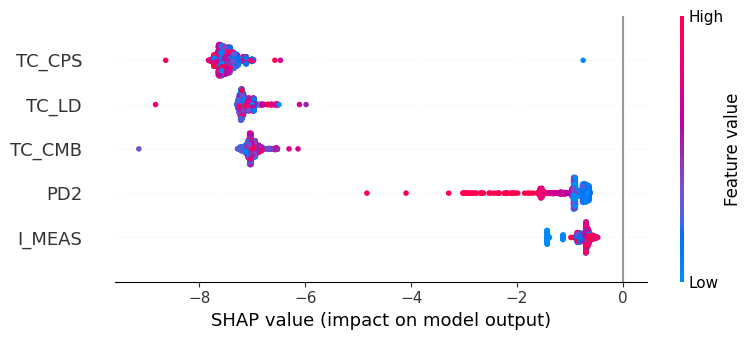

In [4]:
best_model = joblib.load('Created_files/best_isolation_forest_model.pkl')
isolation_forest_model = best_model.named_steps['model']
no_psu_with_fake_data_df_train = pd.read_pickle('Created_files/no_psu_with_fake_data_df_train.pkl')


# Create SHAP explainer
features = ['I_MEAS', 'TC_LD', 'TC_CMB', 'TC_CPS', 'PD2']
X = no_psu_with_fake_data_df_train[features].sample(n=1000, random_state=42)  

# Create SHAP explainer using TreeExplainer
explainer = shap.Explainer(isolation_forest_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X)

# Plot summary
shap.summary_plot(shap_values, X)

#### Key observations:

- Predominantly negative SHAP values across all features, suggesting the model is highly tuned to detect signs of a negative outcome (-1)
- TC_CPS appears to be the most influential feature due to its wide range of SHAP values, TC_LD and TC_CMB also have significant impact
PD2 and I_MEAS have more subtle effects, but still contribute to the model's decisions.
- Overall, Low feature values seems to push the prediction more strongly towards a more negative outcome, while high feature values still contribute to negative predictions but less strongly